In [1]:
import pandas as pd
from configparser import ConfigParser
import psycopg2
import pandas.io.sql as sqlio
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
password = "postgres"

In [3]:

param_dic={
    "host": "energy-analysis.cfcrgd6zjkoj.us-east-2.rds.amazonaws.com",
    "database": "Energy_Analysis",
    "user" : "postgres",
    "password" : password
}

def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

conn = connect(param_dic)

Connecting to the PostgreSQL database...
Connection successful


In [4]:
query="select * from ml_input"

ml_input_df=sqlio.read_sql_query(query,conn)

ml_input_df.head()

,sampno,gender,employment,student,education,drive_freq,transit_freq,tnc_freq,job_type,work_mode,...,autonomous_hhveh,autonomous_rideshare,autonomous_pooled,autonomous_pref,housing,housing_1_8_x,solar,solar_future,income,ev_flag
0,190001,1,4,4,6,3,0,0,,,...,2,2,1,1,2,,2,2,6,0
1,190003,2,4,4,8,1,0,0,,,...,3,1,4,1,1,,2,2,5,0
2,190003,2,4,4,8,1,0,0,,,...,3,1,4,1,1,,2,2,5,0
3,190005,1,4,4,6,2,0,0,,,...,2,2,3,2,1,,2,2,7,0
4,190005,1,4,4,6,2,0,0,,,...,2,2,3,2,1,,2,2,7,0


In [7]:
ml_input_df["ev_flag"].value_counts()

0    16602
1     1238
Name: ev_flag, dtype: int64

In [8]:
query="select * from tbl_main"

main_df=sqlio.read_sql_query(query,conn)

main_df.head()

,sampno,source,language,age_grp,california,county,region,future_decision_role,num_hh_vehicles,household_members_1,...,autonomous_att_8,autonomous_hhveh,autonomous_rideshare,autonomous_pooled,autonomous_pref,housing,housing_1_8_x,solar,solar_future,income
0,192850,4,1,3,1,37,4,1,2,0,...,2,2,3,3,1,1,,2,1,11
1,193449,4,1,3,1,34,6,3,3,0,...,3,2,2,2,3,1,,1,,8
2,193440,4,1,3,1,50,1,1,2,0,...,4,2,3,2,1,1,,2,2,11
3,193133,4,1,4,1,33,2,1,1,0,...,2,2,1,2,3,1,,2,2,7
4,193400,4,1,3,1,1,5,3,3,0,...,4,2,2,2,2,1,,2,2,7


In [9]:
query="select * from tbl_person"

person_df=sqlio.read_sql_query(query,conn)

person_df.head()

,sampno,perid,perno,relationship,gender,employment,student,education,license,vehno,...,school_distance,ethnicity,race_1,race_2,race_3,race_4,race_5,race_6,race_7,race_6_x
0,190001,190001.p01,1,8,1,4,4,6,1,190001.v01,...,,2,0,0,0,0,1,0,0,
1,190003,190003.p01,1,8,2,4,4,8,1,190003.v01,...,,2,0,0,0,0,1,0,0,
2,190002,190002.p01,1,8,2,4,4,1,2,,...,,2,0,0,0,0,1,0,0,
3,190005,190005.p01,1,8,1,4,4,6,1,190005.v02,...,,2,0,0,0,0,1,0,0,
4,190002,190002.p02,2,1,1,1,4,2,1,,...,,2,0,0,0,0,1,0,0,


In [10]:
query="select * from tbl_PEV"

pev_df=sqlio.read_sql_query(query,conn)

pev_df.head()

,sampno,vehno,year,make,model,fuel,veh_type,pev_miles_week,pev_miles_month,phev_percent,...,pev_incentives_2,pev_incentives_3,pev_incentives_4,pev_incentives_5,pev_incentives_6,pev_incentives_7,pev_experience,pev_recommend,pev_confidence,pev_confidence_4_x
0,190107,1,2017,FORD,REDACTED,3,3,250,,30,...,5,4,4,1,1,4,5,5,,
1,190111,3,2018,VOLKSWAGEN,None,5,1,175,,,...,5,5,5,1,1,4,5,4,,
2,190120,2,2016,NISSAN,None,5,2,160,,,...,4,4,4,2,1,2,7,5,,
3,190127,1,2013,TOYOTA,None,3,3,200,,85,...,7,7,7,2,7,5,7,4,,
4,190138,3,2017,CHEVROLET,None,5,2,200,,,...,5,5,5,1,1,1,7,5,2,


In [11]:
#Get the individual respondents
respondent_df = person_df.loc[person_df["relationship"]==8]
respondent_df

,sampno,perid,perno,relationship,gender,employment,student,education,license,vehno,...,school_distance,ethnicity,race_1,race_2,race_3,race_4,race_5,race_6,race_7,race_6_x
0,190001,190001.p01,1,8,1,4,4,6,1,190001.v01,...,,2,0,0,0,0,1,0,0,
1,190003,190003.p01,1,8,2,4,4,8,1,190003.v01,...,,2,0,0,0,0,1,0,0,
2,190002,190002.p01,1,8,2,4,4,1,2,,...,,2,0,0,0,0,1,0,0,
3,190005,190005.p01,1,8,1,4,4,6,1,190005.v02,...,,2,0,0,0,0,1,0,0,
9,190004,190004.p01,1,8,2,4,1,4,2,,...,5,1,0,0,0,0,1,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8358,190792,190792.p01,1,8,1,1,4,6,1,190792.v02,...,,2,0,0,0,0,0,0,1,
8359,190795,190795.p01,1,8,2,1,4,8,1,190795.v01,...,,2,0,0,0,0,0,0,1,
8361,190845,190845.p01,1,8,2,2,4,5,1,190845.v01,...,,2,0,0,0,0,1,0,0,
8362,190803,190803.p01,1,8,2,1,4,8,1,190803.v01,...,,2,0,0,0,0,1,0,0,


In [12]:
#Merge respondents with Main table
respondent_merged_df = main_df.merge(respondent_df, how='left', on='sampno') 
respondent_merged_df

,sampno,source,language,age_grp,california,county,region,future_decision_role,num_hh_vehicles,household_members_1,...,school_distance,ethnicity,race_1,race_2,race_3,race_4,race_5,race_6,race_7,race_6_x
0,192850,4,1,3,1,37,4,1,2,0,...,,2,0,0,0,0,1,0,0,
1,193449,4,1,3,1,34,6,3,3,0,...,,1,0,0,0,0,1,0,0,
2,193440,4,1,3,1,50,1,1,2,0,...,,2,0,0,0,0,1,0,0,
3,193133,4,1,4,1,33,2,1,1,0,...,,2,0,0,0,0,1,0,0,
4,193400,4,1,3,1,1,5,3,3,0,...,,2,0,1,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,190256,2,1,3,1,19,2,2,3,1,...,,1,0,0,0,0,1,0,0,
4244,191249,5,1,3,1,30,2,3,3,0,...,,2,0,1,0,0,0,0,0,
4245,190327,2,1,3,1,36,2,2,3,0,...,,2,0,0,0,0,1,0,0,
4246,191658,5,1,4,1,19,2,2,3,1,...,,2,0,0,0,0,1,0,0,


In [13]:
#Get list of all PEV owners
PEV_owners=pev_df.sampno 
PEV_owners.tolist()
len(PEV_owners)


451

In [14]:
#Create PEV owner column, populate from list
respondent_merged_df["PEV owner"] = "No"
for owner in PEV_owners:
    respondent_merged_df.loc[respondent_merged_df.sampno == owner,'PEV owner'] = "Yes"

In [15]:
#Create new 'Genders' column with 3 labels.
respondent_merged_df["Genders"] =respondent_merged_df[""] = "Other"
respondent_merged_df.loc[respondent_merged_df.gender == 1,'Genders'] = "Male"
respondent_merged_df.loc[respondent_merged_df.gender == 2,'Genders'] = "Female"

In [21]:
#Seperate df for PEV's and non PEVS (In case we want'em)
owner_merged_df =respondent_merged_df.loc[respondent_merged_df['PEV owner'] == "Yes"]
owner_merged_df

,sampno,source,language,age_grp,california,county,region,future_decision_role,num_hh_vehicles,household_members_1,...,race_2,race_3,race_4,race_5,race_6,race_7,race_6_x,PEV owner,Genders,
40,192569,4,1,3,1,31,6,2,4,0,...,0,0,0,1,0,0,,Yes,Female,Other
41,192756,4,1,3,1,37,4,1,2,0,...,0,0,0,1,0,0,,Yes,Female,Other
105,192597,4,1,3,1,7,5,2,2,0,...,0,0,0,1,0,0,,Yes,Female,Other
129,192047,4,1,3,1,1,5,2,3,0,...,0,0,0,1,0,0,,Yes,Female,Other
132,192359,4,1,4,1,40,3,3,2,0,...,0,0,0,1,0,0,,Yes,Female,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240,194031,5,1,2,1,19,2,1,3,0,...,0,0,0,1,0,0,,Yes,Male,Other
4241,190293,2,1,3,1,37,4,3,3,0,...,1,0,0,0,0,0,,Yes,Male,Other
4242,190650,5,1,3,1,27,3,1,3,0,...,0,0,0,1,0,0,,Yes,Male,Other
4243,190256,2,1,3,1,19,2,2,3,1,...,0,0,0,1,0,0,,Yes,Male,Other


In [22]:
nonowner_merged_df =respondent_merged_df.loc[respondent_merged_df['PEV owner'] == "No"]
nonowner_merged_df

,sampno,source,language,age_grp,california,county,region,future_decision_role,num_hh_vehicles,household_members_1,...,race_2,race_3,race_4,race_5,race_6,race_7,race_6_x,PEV owner,Genders,
0,192850,4,1,3,1,37,4,1,2,0,...,0,0,0,1,0,0,,No,Male,Other
1,193449,4,1,3,1,34,6,3,3,0,...,0,0,0,1,0,0,,No,Female,Other
2,193440,4,1,3,1,50,1,1,2,0,...,0,0,0,1,0,0,,No,Female,Other
3,193133,4,1,4,1,33,2,1,1,0,...,0,0,0,1,0,0,,No,Female,Other
4,193400,4,1,3,1,1,5,3,3,0,...,1,0,0,0,0,0,,No,Female,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4238,191231,5,1,4,1,30,2,3,2,0,...,0,0,0,1,0,0,,No,Male,Other
4239,190906,5,1,3,1,1,5,3,6,0,...,0,0,0,1,0,0,,No,Male,Other
4244,191249,5,1,3,1,30,2,3,3,0,...,1,0,0,0,0,0,,No,Male,Other
4246,191658,5,1,4,1,19,2,2,3,1,...,0,0,0,1,0,0,,No,Male,Other


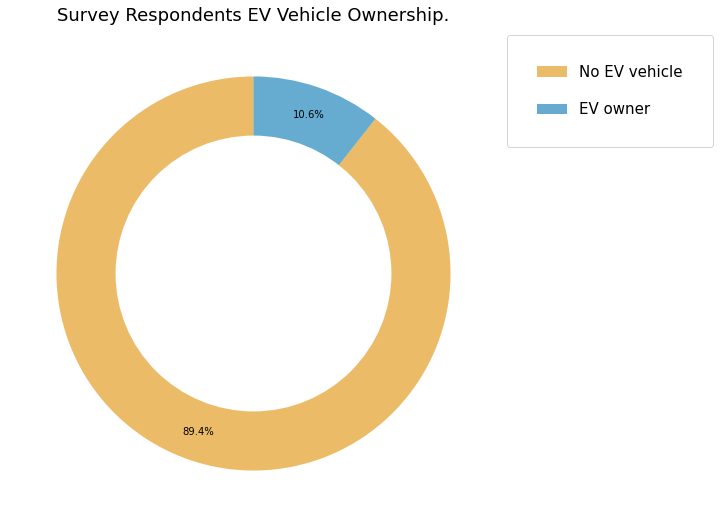

In [19]:
#Create Donut of owners v Non-owners
fig, ax = plt.subplots(1,figsize=(10,10)) #ax1,ax2 refer to your two pies
labels = ["No EV vehicle","EV owner"]
values =(respondent_merged_df['PEV owner'].value_counts())
#colors
colors = ["#de8f05", "#0173b2"]
#explsion
explode = (0.0,0.0,0.00)
 
ax.pie(values, colors = colors,wedgeprops={'alpha':0.6}, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
ax.set_title('Survey Respondents EV Vehicle Ownership.', fontsize=18)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax.axis('equal')  
ax.legend(labels,bbox_to_anchor=(1, 1),borderpad=2,labelspacing=1.5,prop={"size":15})
plt.tight_layout()
plt.show()

# Compare to populations (PEV/Non-PEV)


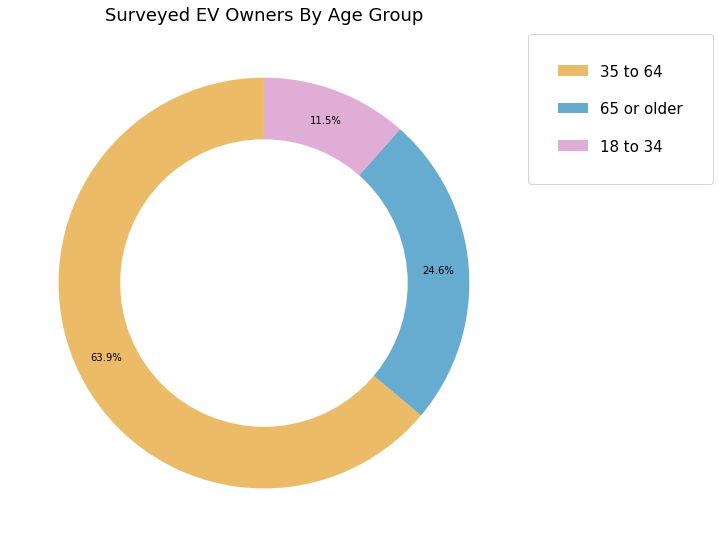

In [24]:
#EV owners by age donut
# Pie chart
fig, ax = plt.subplots(1,figsize=(10,10)) #ax1,ax2 refer to your two pies
labels = ["35 to 64 ","65 or older","18 to 34"]
values =(owner_merged_df['age_grp'].value_counts())
#colors
colors = ['#de8f05','#0173b2','#cc78bc']
#explsion
explode = (0.0,0.0,0.00)
 
ax.pie(values, colors = colors,wedgeprops={'alpha':0.6},autopct='%1.1f%%', startangle=90, pctdistance=0.85)
ax.set_title('Surveyed EV Owners By Age Group', fontsize=18)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
ax.legend(labels,bbox_to_anchor=(1, 1),borderpad=2,labelspacing=1.5,prop={"size":15})
plt.tight_layout()
plt.show()

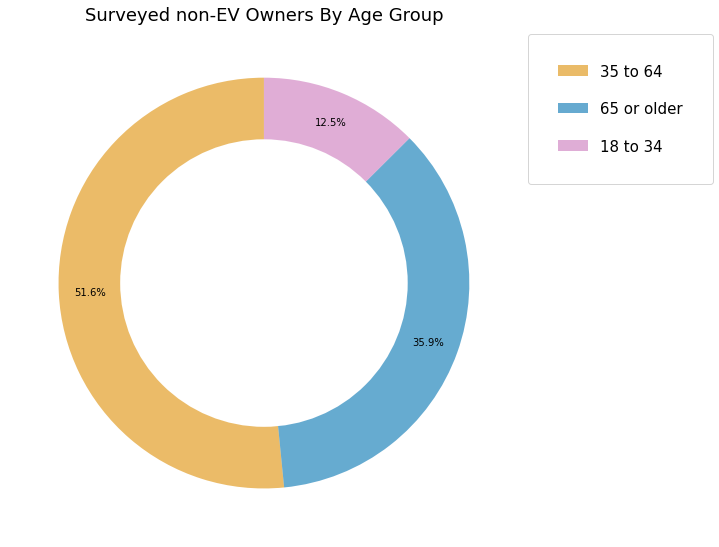

In [26]:
fig, ax = plt.subplots(1,figsize=(10,10)) #ax1,ax2 refer to your two pies
labels = ["35 to 64 ","65 or older","18 to 34"]
values =(nonowner_merged_df['age_grp'].value_counts())
#colors
colors = ['#de8f05','#0173b2','#cc78bc']
#explsion
explode = (0.0,0.0,0.00)
 
ax.pie(values, colors = colors,wedgeprops={'alpha':0.6}, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
ax.set_title('Surveyed non-EV Owners By Age Group', fontsize=18)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
ax.legend(labels,bbox_to_anchor=(1, 1),borderpad=2,labelspacing=1.5,prop={"size":15})
plt.tight_layout()
plt.show()